# Fruit classifier - Vision Transformer ViT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reference used in this project: https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os

import pandas as pd
import numpy as np

# Image loading and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Target network's classifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, InputLayer

# training
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# evaluation
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import models

import time

%matplotlib inline

In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow_addons 

import tensorflow_addons as tfa
from vit_keras import vit

# Prepare sample data for feature extractor and classifier modelling

ImageDataGenerator used to load images into memory

```

In [ ]:
# Prepare labels, used for test
labels = [ 'Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi' ]

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [ ]:
img_height = img_width = 224 
channels = 3

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=data_augment) 

X_train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/data/fruit-360/Training40',
                                                target_size=(img_height, img_width),
                                                batch_size=32, shuffle=False)


X_train, y_train = next(X_train_gen)

Found 20369 images belonging to 40 classes.


In [ ]:
X_train.shape, y_train.shape

((32, 224, 224, 3), (32, 40))

In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=data_augment) 

X_val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/data/fruit-360/Validation40',
                                                target_size=(img_height, img_width),
                                                batch_size=32, shuffle=False)

X_val, y_val = next(X_val_gen)

Found 3422 images belonging to 40 classes.


In [ ]:
X_val.shape, y_val.shape

((32, 224, 224, 3), (32, 40))

# Prepare Feature Extractor component

In [ ]:
IMAGE_SIZE=224

model_featurizer = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 40) # exclude classifier

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


# Prepare Classifier component

In [ ]:
sample_batch_train = X_train
sample_batch_val = X_val

featOutput_train = model_featurizer.predict(sample_batch_train)
featOutput_val = model_featurizer.predict(sample_batch_val)

featOutput_train.shape, featOutput_val.shape

((32, 768), (32, 768))

In [ ]:
num_classes = 40

def classifier():
    inputs = Input(shape = (featOutput_train.shape[1:]), name="Input_Classifer")
    x = Flatten()(inputs)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)

    x = Dense(num_classes, activation='softmax')(x) 
                                                    
    classfier = Model(inputs=[inputs],outputs=[x])
    return classfier

In [ ]:
clf = classifier()
clf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Classifer (InputLayer  [(None, 768)]            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 500)               384500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 40)                4040      
                                                             

### Test feature extractor and classifier components can integrate

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

clf.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])


clf.fit(featOutput_train, y_train,
          batch_size=32,
          validation_data = (featOutput_val, y_val),
          epochs = 1)

1/1 [==============================] - 4s 4s/step - loss: 4.1155 - accuracy: 0.0000e+00 - val_loss: 3.6854 - val_accuracy: 0.0000e+00


# Combine feature extractor and classifier

### Prepare data generator for training 

In [ ]:
n_train_set= 256
n_val_set = 256

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=data_augment) 

X_train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/data/fruit-360/Training40',
                                                target_size=(img_height, img_width),
                                                batch_size=n_train_set, shuffle=True)

#-----------------------------------------------------------------------------------#

val_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=data_augment) 

X_val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/data/fruit-360/Validation40',
                                                target_size=(img_height, img_width),
                                                batch_size=n_val_set, shuffle=True)   # no need to shuffle for testing

Found 20369 images belonging to 40 classes.
Found 3422 images belonging to 40 classes.


In [ ]:
featurizer = model_featurizer

# Append the classifier trained earlier to the featurizer
#   Classifier's input is featurizer's output
#   Model's output is classifier's output

combined_model = Model(inputs=featurizer.input,
                       outputs=clf(featurizer.output))

# Freeze layers up to the last 3th layer (non-inclusive)
for layer in combined_model.layers[:-1]:
    layer.trainable = False # freeze

print(combined_model.layers[-3].name + "\n")    
    
combined_model.summary()

Transformer/encoder_norm

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (No

In [ ]:
combined_model.layers[-2], combined_model.layers[-1]

(<keras.layers.core.lambda_layer.Lambda at 0x7f18c0729e90>,
 <keras.engine.functional.Functional at 0x7f18c006dfd0>)

## train model

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

combined_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = X_train_gen.n // X_train_gen.batch_size
STEP_SIZE_VALID = X_val_gen.n // X_val_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]


records = combined_model.fit(x = X_train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = X_val_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = 8,
          callbacks = callbacks)


Epoch 1/8
79/79 [==============================] - ETA: 0s - loss: 3.8802 - accuracy: 0.0463
Epoch 00001: val_accuracy improved from -inf to 0.10637, saving model to ./model.hdf5
79/79 [==============================] - 474s 6s/step - loss: 3.8802 - accuracy: 0.0463 - val_loss: 3.5181 - val_accuracy: 0.1064 - lr: 1.0000e-04
Epoch 2/8
79/79 [==============================] - ETA: 0s - loss: 3.2820 - accuracy: 0.2229
Epoch 00002: val_accuracy improved from 0.10637 to 0.49219, saving model to ./model.hdf5
79/79 [==============================] - 428s 5s/step - loss: 3.2820 - accuracy: 0.2229 - val_loss: 2.8441 - val_accuracy: 0.4922 - lr: 1.0000e-04
Epoch 3/8
79/79 [==============================] - ETA: 0s - loss: 2.5604 - accuracy: 0.5679
Epoch 00003: val_accuracy improved from 0.49219 to 0.79237, saving model to ./model.hdf5
79/79 [==============================] - 426s 5s/step - loss: 2.5604 - accuracy: 0.5679 - val_loss: 2.1037 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 4/8
79/79 

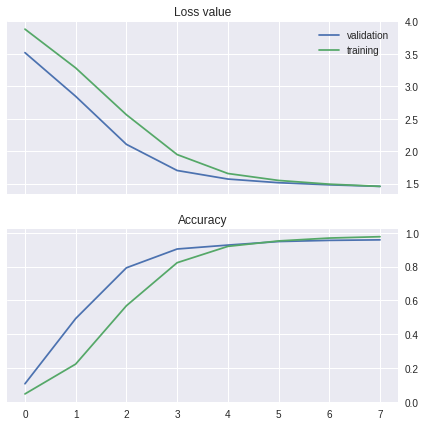

In [ ]:
plt.style.use('seaborn')                   
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   


plt.figure()
plt.subplot(211)
plt.plot(records.history['val_loss'], label="validation")
plt.plot(records.history['loss'],label="training")
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records.history['val_accuracy'],label="validation")
plt.plot(records.history['accuracy'],label="training")
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

---------------------------

------------------------

# Test on unseen data

### Prepare data generator for testing

In [ ]:

batch_num = 3410

test_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=0.4,
#     horizontal_flip=True,
    preprocessing_function=data_augment)


X_test_gen = test_datagen.flow_from_directory('/content/drive/MyDrive/data/fruit-360/Testing40',
                                             target_size=(img_height, img_width),
                                             batch_size=batch_num, shuffle=False)

# not using y labels
batch_test = next(X_test_gen)
X_test = batch_test[0]
y_test = batch_test[1]

X_test.shape, y_test.shape

Found 3410 images belonging to 40 classes.


((3410, 224, 224, 3), (3410, 40))

In [ ]:
y_test[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# Predictions

# feed the images directly to the combined model
pred = combined_model.predict(X_test)

# convert from probabilities to labels
pred_label_index = pred.argmax(axis=1) 

In [ ]:
# Reference
# labels: ['Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
#          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
#          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
#          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi']

In [ ]:
truth = y_test.argmax(axis=1) 

index = 1
print('actual', labels[truth[index]], 'predicted', labels[pred_label_index[index]])

actual Apple Braeburn predicted Apple Braeburn


In [ ]:
truth = y_test.argmax(axis=1) 
truth.shape

(3410,)

In [ ]:
print(confusion_matrix(truth, pred_label_index))
print(classification_report(truth, pred_label_index, target_names=labels))

[[80  0  0 ...  0  0  0]
 [ 1 79  0 ...  0  0  0]
 [ 0  0 70 ...  0  0  0]
 ...
 [ 0  0  0 ... 82  0  0]
 [ 1  0  0 ...  0 79  0]
 [ 0  0  0 ...  0  0 78]]
                    precision    recall  f1-score   support

    Apple Braeburn       0.96      0.98      0.97        82
           Apricot       0.93      0.96      0.95        82
           Avocado       1.00      1.00      1.00        70
      Avocado ripe       1.00      0.98      0.99        83
            Banana       0.93      0.98      0.95        83
Banana Lady Finger       0.97      0.89      0.93        76
        Banana Red       0.99      0.99      0.99        83
          Beetroot       0.96      0.92      0.94        75
         Blueberry       0.94      1.00      0.97        77
      Cactus fruit       0.94      1.00      0.97        83
      Cantaloupe 1       0.96      1.00      0.98        82
      Cantaloupe 2       0.81      0.95      0.88        82
         Carambula       1.00      0.98      0.99        83
   

In [ ]:
combined_model.save("/content/drive/MyDrive/data/fruit-360/vit_model.h5")

------------------------------------

-----------------------------